<a href="https://colab.research.google.com/github/AnLiMan/CAN-interpret-For-J1939/blob/main/CAN_decoder_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Описание

Текст



# Настройки

In [13]:
csv_file = 'https://raw.githubusercontent.com/AnLiMan/CAN-interpret-For-J1939/main/Logs/Data_5.csv'  # Ссылка на логи
df = pd.read_csv(csv_file, skip_blank_lines=True, skiprows=3)

# Библиотеки

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [16]:
csv_file = 'https://raw.githubusercontent.com/AnLiMan/CAN-interpret-For-J1939/main/Logs/Data_5.csv'
df = pd.read_csv(csv_file) # Прочтём датасет
df.head() # Выведем заголовок

/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,Time,Unnamed: 1,ID (hex),Data (hex)
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


#Подготовка данных


Статистика по CAN ID:
ID (hex)
18FF0104    59
18FEF704    59
18FFF504    59
18FFF403    23
18FFF003    22
18FFF103    22
18FEF803    22
18F00400    21
CFDD680      8
CFDD780      8
18FEF500     2
18FEEF00     2
18FEF700     1
18FEE500     1
18EEFF17     1
18FEE400     1
18FD0700     1
18FEE900     1
18FECA03     1
18FEEE00     1
18EA0017     1
Name: count, dtype: int64

Пример обработанных данных:
                     Time  ID (hex)               Data (hex)  priority  \
5 1900-01-01 15:35:54.683  18FFF403  00 00 00 00 00 00 00 00         6   
6 1900-01-01 15:35:54.688  18FF0104  08 10 00 00 A4 04 02 00         6   
7 1900-01-01 15:35:54.689  18FFF003  00 00 00 00 00 00 00 00         6   
8 1900-01-01 15:35:54.692  18FEF704  FF FF FF FF 6A 00 FF FF         6   
9 1900-01-01 15:35:54.694  18FFF103  04 00 00 00 00 00 00 FF         6   

   pdu_format  source_address  can_id_full  byte_1  byte_2  byte_3  byte_4  \
5         255               3    419427331     0.0     0.0     0.0     0.0 

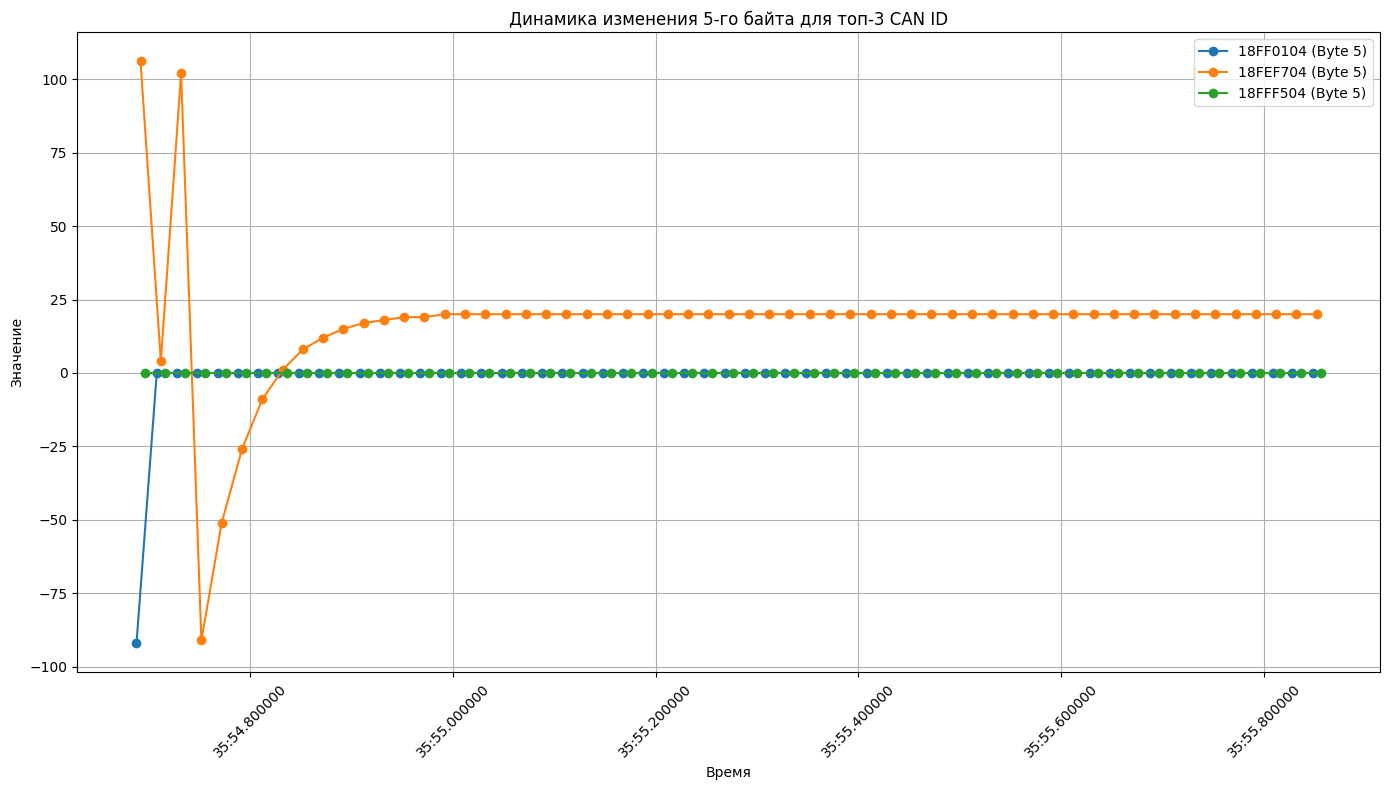

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Загрузка данных
csv_file = 'https://raw.githubusercontent.com/AnLiMan/CAN-interpret-For-J1939/main/Logs/Data_5.csv'
df = pd.read_csv(csv_file)

# Выбираем только нужные столбцы и фильтруем Remote Frame
df = df[['Time', 'ID (hex)', 'Data (hex)']].copy()
df = df[~df['Data (hex)'].str.contains('Remote Frame', na=False)]

# Функции для обработки данных
def clean_hex(hex_str):
    """Очистка HEX-строки"""
    if pd.isna(hex_str) or 'Remote' in str(hex_str):
        return None
    return hex_str.strip()

def parse_j1939_id(can_id_hex):
    """Разбор CAN ID по протоколу J1939"""
    try:
        can_id = int(can_id_hex, 16)
        priority = (can_id >> 26) & 0x7
        pdu_format = (can_id >> 16) & 0xFF
        source_address = can_id & 0xFF

        return {
            'priority': priority,
            'pdu_format': pdu_format,
            'source_address': source_address,
            'can_id_full': can_id
        }
    except:
        return None

def hex_to_signed(hex_str):
    """Преобразование HEX в знаковое целое"""
    if not isinstance(hex_str, str) or len(hex_str.strip()) == 0:
        return None
    try:
        num = int(hex_str, 16)
        return num - 256 if num > 127 else num
    except:
        return None

def parse_can_data(data_hex):
    """Разбор данных CAN"""
    try:
        bytes_list = data_hex.strip().split()
        return {f'byte_{i}': hex_to_signed(byte) for i, byte in enumerate(bytes_list, 1)}
    except:
        return {f'byte_{i}': None for i in range(1, 9)}

# Применяем функции очистки
df['ID (hex)'] = df['ID (hex)'].apply(clean_hex)
df['Data (hex)'] = df['Data (hex)'].apply(clean_hex)

# Удаляем строки с пустыми данными
df = df.dropna(subset=['ID (hex)', 'Data (hex)'])

# Парсим ID и данные
j1939_data = df['ID (hex)'].apply(parse_j1939_id).apply(pd.Series)
can_data = df['Data (hex)'].apply(parse_can_data).apply(pd.Series)

# Объединяем всё в один DataFrame
df = pd.concat([df, j1939_data, can_data], axis=1)

# Преобразуем время
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S.%f')

# Анализ данных
print("\nСтатистика по CAN ID:")
print(df['ID (hex)'].value_counts())

print("\nПример обработанных данных:")
print(df.head())

# Визуализация для топ-3 CAN ID
top_ids = df['ID (hex)'].value_counts().index[:3]

plt.figure(figsize=(14, 8))
for can_id in top_ids:
    subset = df[df['ID (hex)'] == can_id]
    if not subset.empty:
        plt.plot(subset['Time'], subset['byte_5'],
                marker='o', linestyle='-',
                label=f'{can_id} (Byte 5)')

plt.title('Динамика изменения 5-го байта для топ-3 CAN ID')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()